In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.data.metrics import get_metrics, get_tumbling_top_5_accuracy, get_top_1_accuracy

In [9]:
df = pd.read_json("../reports/ablation_levels.jsonl", lines=True, orient='records')
df['loc_level'] = df['loc_level'].fillna("all")
get_metrics(df, ['tumbling_top_5_accuracy', 'tumbling_top_1_accuracy'])

In [ ]:
dataset = "foursquare_NYC"
model = "BiTULER"
dfp = df[(df["model_cls"] == model) & (df["dataset"] == dataset)]


In [20]:
def exponential_smoothing(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

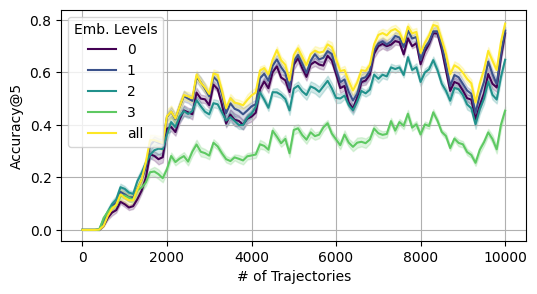

In [71]:
smoothing_window = 5
metric = "tumbling_top_5_accuracy"
dataset = "foursquare_NYC"
subsample = 101
model = "TULHOR"
dfp = df[(df["dataset"] == dataset) & (df["model_cls"] == model)]
fig, ax = plt.subplots(nrows=1, figsize=(6, 3), sharex="col")

# Generate colors from the viridis colormap
loc_levels = [0, 1, 2, 3, "all"]
cmap = plt.get_cmap("viridis", len(loc_levels))
colors = cmap(range(len(loc_levels)))

for level_idx, level in enumerate(loc_levels):
    df_level = dfp[dfp["loc_level"] == level]
    all_top_5_accuracy = np.stack(df_level[metric].values)
    color = colors[level_idx]
    y = (all_top_5_accuracy).mean(axis=0)[:subsample]
    y = exponential_smoothing(y, smoothing_window)
    x = np.arange(len(y)) * 100
    std = all_top_5_accuracy.std(axis=0)[:subsample]
    std = exponential_smoothing(std, smoothing_window)
    label = "All" if level == "all" else level
    ax.plot(x, y, label=level, color=color)
    ax.fill_between(x, y - std, y + std, alpha=0.2, color=color)
    ax.set_ylabel("Accuracy@5")
    ax.grid()
ax.set_xlabel("# of Trajectories")
fig.get_tight_layout()
ax.legend(title="Emb. Levels")

Prequential top-5 accuracy of TULHOR with only one or all embedding levels for the first 10k trajectories of foursquare_NYC. 

At the start, the model with the higher level embedding 2 & 3 adapt more quickly outperforming the level 0 variant up until 1500 trajectories have been observed. After that, the latter performs almost always better but shows a larger sensitivity to distribution shifts as can be seen by its larger dips in accuracy around 4000 and 6000 samples.

The model with all embedding levels appears to combine the the stability of the higher level embeddings with the peak accuracy of the finegrained ones to some extent. 